In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import xgboost
import shap
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()

In [22]:
# Load the data
df_signals_2016 = pd.read_csv('CSV\wind-farm-signals-2016.csv', sep=';')
df_signals_2017 = pd.read_csv('CSV\wind-farm-signals-2017.csv', sep=';')
df_metmast_2016 = pd.read_csv('CSV\wind-farm-metmast-2016.csv', sep=';')
df_metmast_2017 = pd.read_csv('CSV\wind-farm-metmast-2017.csv', sep=';')
df_powercurve = pd.read_excel('powercurve.xlsx')

In [31]:
def process_data():    
    # Merge dataframes
    frames1 = [df_signals_2016, df_signals_2017]
    df1 = pd.concat(frames1, ignore_index=True)
    # Convert to datetime and remove time zone
    df1['Timestamp'] = pd.to_datetime(df1['Timestamp']).dt.tz_localize(None)

    frames2 = [df_metmast_2016, df_metmast_2017]
    df2 = pd.concat(frames2, ignore_index=True)
    df2['Timestamp'] = pd.to_datetime(df2['Timestamp']).dt.tz_localize(None)

    # Join dataframes on index 'Timestamp'
    df = df1.set_index('Timestamp').join(df2.set_index('Timestamp'))

    # Select turbine
    turbine = 'T07'
    df = df.loc[df['Turbine_ID'] == turbine].reset_index()

    # Extract only relevant columns
    df = df[['Timestamp', 'Turbine_ID', 'Gen_Bear_Temp_Avg', 'Gen_RPM_Avg', 
             'Nac_Temp_Avg', 'Amb_WindSpeed_Avg', 'Avg_Humidity', 
             'Gen_Phase1_Temp_Avg', 'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg', 
#              'Amb_WindDir_Abs_Avg', 'Grd_Prod_Pwr_Avg'
            ]].copy()

    # Rename columns
    df = df.rename(columns={'Timestamp': 'Date',
                            'Gen_Bear_Temp_Avg': 'Gen_Bear_Temp',
                            'Gen_RPM_Avg': 'Gen_RPM',
                            #'Gen_Bear2_Temp_Avg': 'Gen_Bear2_Temp',
                            'Nac_Temp_Avg': 'Nac_Temp', 
                            'Amb_WindSpeed_Avg': 'Wind_Speed', 
                            'Avg_Humidity': 'Humidity',
                            'Gen_Phase1_Temp_Avg': 'Gen_Phase1_Temp', 
                            'Gen_Phase2_Temp_Avg': 'Gen_Phase2_Temp',
                            'Gen_Phase3_Temp_Avg': 'Gen_Phase3_Temp', 
                            'Amb_WindDir_Abs_Avg' : 'Wind_Dir',
                            'Grd_Prod_Pwr_Avg': 'Prod_Pwr'})

    df['Gen_Phase_Temp'] = df[['Gen_Phase1_Temp', 'Gen_Phase2_Temp', 'Gen_Phase3_Temp']].mean(axis=1)
    df = df.drop(columns=['Gen_Phase1_Temp', 'Gen_Phase2_Temp', 'Gen_Phase3_Temp'])

    # Fill the missing Gen_Bear_Temp nan value with the the mean of the values diorectly next to it
    df.Gen_Bear_Temp = df.Gen_Bear_Temp.fillna(48)
    df = df.loc[df['Gen_Bear_Temp'] < 100]

    # Combine duplicates by their mean
    df = df.groupby('Date').mean()
    
    return df

In [32]:
df = process_data()

In [30]:
# Merge dataframes
frames1 = [df_signals_2016, df_signals_2017]
df1 = pd.concat(frames1, ignore_index=True)
# Convert to datetime and remove time zone
df1['Timestamp'] = pd.to_datetime(df1['Timestamp']).dt.tz_localize(None)

frames2 = [df_metmast_2016, df_metmast_2017]
df2 = pd.concat(frames2, ignore_index=True)
df2['Timestamp'] = pd.to_datetime(df2['Timestamp']).dt.tz_localize(None)

# Join dataframes on index 'Timestamp'
df = df1.set_index('Timestamp').join(df2.set_index('Timestamp'))

# Select turbine
turbine = 'T07'
df = df.loc[df['Turbine_ID'] == turbine].reset_index()

# Extract only relevant columns
df = df[['Timestamp', 'Turbine_ID', 'Gen_Bear_Temp_Avg', 'Gen_RPM_Avg', 
         'Nac_Temp_Avg', 'Amb_WindSpeed_Avg', 'Avg_Humidity', 
         'Gen_Phase1_Temp_Avg', 'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg', 
        # 'Amb_WindDir_Abs_Avg', 'Grd_Prod_Pwr_Avg'
        ]].copy()

# Rename columns
df = df.rename(columns={'Timestamp': 'Date',
                        'Gen_Bear_Temp_Avg': 'Gen_Bear_Temp',
                        'Gen_RPM_Avg': 'Gen_RPM',
                        #'Gen_Bear2_Temp_Avg': 'Gen_Bear2_Temp',
                        'Nac_Temp_Avg': 'Nac_Temp', 
                        'Amb_WindSpeed_Avg': 'Wind_Speed', 
                        'Avg_Humidity': 'Humidity',
                        'Gen_Phase1_Temp_Avg': 'Gen_Phase1_Temp', 
                        'Gen_Phase2_Temp_Avg': 'Gen_Phase2_Temp',
                        'Gen_Phase3_Temp_Avg': 'Gen_Phase3_Temp', 
                        'Amb_WindDir_Abs_Avg' : 'Wind_Dir',
                        'Grd_Prod_Pwr_Avg': 'Prod_Pwr'})

#df['Gen_Phase_Temp'] = df[['Gen_Phase1_Temp', 'Gen_Phase2_Temp', 'Gen_Phase3_Temp']].mean(axis=1)
#df = df.drop(columns=['Gen_Phase1_Temp', 'Gen_Phase2_Temp', 'Gen_Phase3_Temp'])

# Fill the missing Gen_Bear_Temp nan value with the the mean of the values diorectly next to it
#df.Gen_Bear_Temp = df.Gen_Bear_Temp.fillna(48)
#df = df.loc[df['Gen_Bear_Temp'] < 100]

# Combine duplicates by their mean
df = df.groupby('Date').mean()

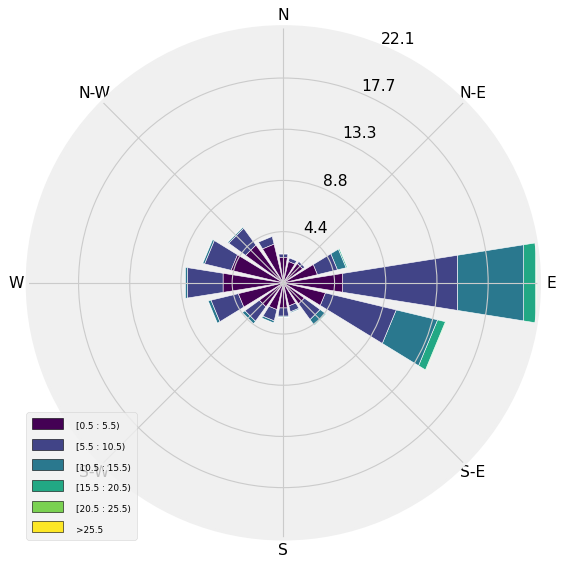

In [16]:
from windrose import WindroseAxes
ax = WindroseAxes.from_ax()
ax.bar(df.Wind_Dir, df.Wind_Speed, normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.show()

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


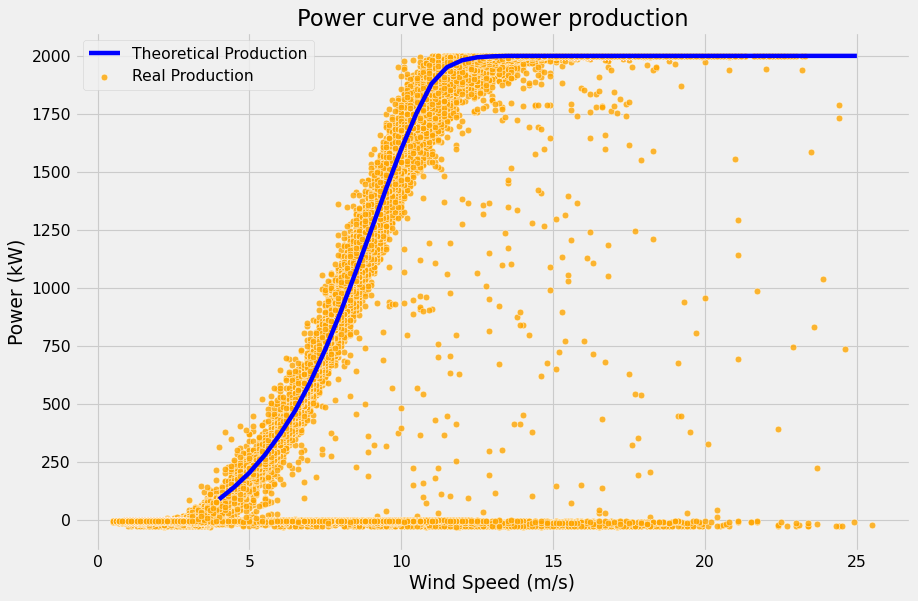

In [18]:
plt.figure(figsize=(12,8), dpi=80)
sns.scatterplot(df['Wind_Speed'], y=df['Prod_Pwr'], color='orange', label='Real Production', alpha=0.8)
sns.lineplot(df_powercurve['WindSpeed'], y=df_powercurve['Power'], color='blue', label='Theoretical Production')
plt.title('Power curve and power production')
plt.ylabel('Power (kW)');
plt.xlabel('Wind Speed (m/s)');

<AxesSubplot:xlabel='Gen_Bear_Temp', ylabel='Gen_RPM'>

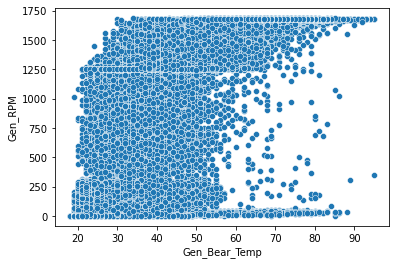

In [76]:
sns.scatterplot(x='Gen_Bear_Temp',
                y='Gen_RPM',
               # hue="Gen_Bear_Temp",
               data=df)


In [4]:
np.count_nonzero(np.isnan(df[:'2016-12-31 23:50:00']))

4

In [476]:
from time import perf_counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, mean_squared_error


sns.set(style='darkgrid', context='talk', palette='rainbow')
n = 10**4
X, y = make_classification(n, random_state=42)
X = pd.DataFrame(X, columns=[f'feature{i}' for i in range(X.shape[1])])
# Randomly add missing data for all columns
for i, col in enumerate(X.columns):
    np.random.seed(i)
    X.loc[np.random.choice(range(n), 1000, replace=False), col] = np.nan
print(f"Target shape: {y.shape}")
print(f"Features shape: {X.shape}")
X.head()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print("========== Training data ========== ")
print(f"Features: {X_train.shape} | Target:{y_train.shape}")
print("========== Test data ========== ")
print(f"Features: {X_test.shape} | Target:{y_test.shape}")
hgbm = HistGradientBoostingClassifier(random_state=42)
hgbm.fit(X_train, y_train)
hgbm.score(X_test, y_test)

Target shape: (10000,)
Features shape: (10000, 20)
========== Training data ========== 
Features: (7500, 20) | Target:(7500,)
========== Test data ========== 
Features: (2500, 20) | Target:(2500,)


0.9248

In [ ]:
df.loc[df['WindSpeed'] > 25]
df.loc[df['WindSpeed'] < 2]
#plt.hist(df['WindSpeed'], bins=26)

In [ ]:
# splitting the dataset
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

#X = df.drop("Gen_Bear_Temp", axis=1).values
#y = df["Gen_Bear_Temp"].values.astype('int')

#create feature and targets
features = df.drop('Gen_Bear_Temp', axis=1).values
target = df['Gen_Bear_Temp'].values.astype('int')
#split data into 80% training and 20% test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42, stratify=target)

#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
print("========== Training data ========== ")
print(f"Features: {X_train.shape} | Target:{y_train.shape}")
print("========== Test data ========== ")
print(f"Features: {X_test.shape} | Target:{y_test.shape}")

# training the model
hgbm = HistGradientBoostingClassifier(random_state=42)
model = hgbm.fit(X_train, y_train)
hgbm.score(X_test, y_test)

#from sklearn.model_selection import cross_val_score
#CVscores = cross_val_score(hgbm, X_train, y_train, scoring='roc_auc', cv=2) 
#print("The average CV score is", CVscores.mean())

features = df[['Gen_RPM', 'Nac_Temp', 'WindSpeed', 'Humidity', 'Gen_Phase_Temp']].to_numpy()

prediction = hgbm.predict(features)

In [ ]:
span1 = 75000
span2 = 87000

plt.figure(figsize=(25, 10), dpi=80)
plt.plot(df[span1:span2].index, prediction[span1:span2], color='r', label='Predicted')
plt.plot(df[span1:span2].index, df['Gen_Bear_Temp'][span1:span2], color='g', label='Actual')
plt.title('Predicted vs Actual')
plt.ylabel('Generator Bearing Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
mean_squared_error(target, prediction)

In [ ]:
# splitting the dataset
#df1 = df[df['Gen_Bear_Temp'].notna()]
test_size = 0.5
k = 3
x = df.drop("Gen_Bear_Temp", axis=1).values.astype('int')
y = df["Gen_Bear_Temp"].astype('int')
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=test_size, 
                                                    random_state=1)
# training the model
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(x_train, y_train)
# giving inputs to the machine learning model
features = df[['Gen_RPM', 'Nac_Temp', 'WindSpeed', 'Humidity', 'Gen_Phase_Temp']].to_numpy()
# using inputs to predict the output
prediction = knn.predict(features)

span = 99000
plt.figure(figsize=(15, 10), dpi=80)
plt.plot(df[span:].index, prediction[span:], color='r', label='Predicted')
plt.plot(df[span:].index, df['Humidity'][span:], color='g', label='Actual')
plt.title('Predicted vs Actual')
plt.ylabel('Generator Bearing Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
type(x_train)

In [ ]:
print(df1.dtypes)
type(y_train)

In [ ]:
# splitting the dataset
df1 = df.drop('Humidity', axis=1)
df1 = df1.astype('int')

#df1 = df1[df1['Gen_Bear_Temp'].notna()]
#df1 = df1.reset_index()
#df1 = df1.set_index('Date')
#df1.Gen_Phase_Temp = df1.Gen_Phase_Temp.round()
#df1 = df1.round({'Gen_Phase_Temp': 1})
test_size = 0.5

k = 3
x = df1.drop("Gen_Bear_Temp", axis=1).values
y = df1["Gen_Bear_Temp"]
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=test_size, 
                                                    random_state=1)
# training the model
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(x_train, y_train)
# giving inputs to the machine learning model
features = df1[['Gen_RPM', 'Nac_Temp', 'WindSpeed', 'Gen_Phase_Temp']].to_numpy()
# using inputs to predict the output
prediction = knn.predict(features)

span = 70000
plt.figure(figsize=(25, 5), dpi=80)
plt.plot(df1[span:].index, prediction[span:], color='r', label='Predicted')
plt.plot(df1[span:].index, df1['Gen_Bear_Temp'][span:], color='g', label='Actual')
plt.title('Predicted vs Actual')
plt.ylabel('Generator Bearing Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.show()

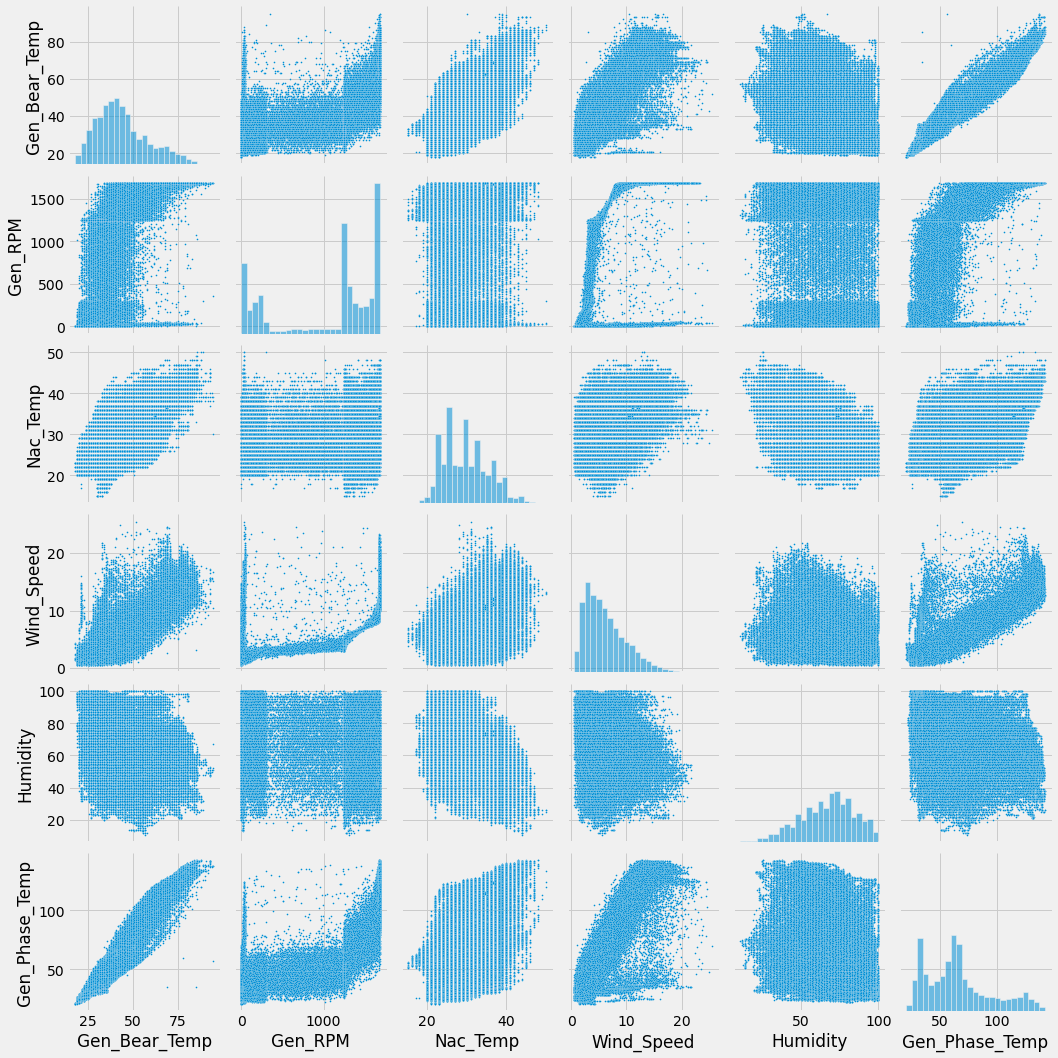

In [34]:
sns.pairplot(df, diag_kind = "hist", 
             diag_kws = {'alpha':0.55, 'bins':25}, plot_kws={"s": 3})

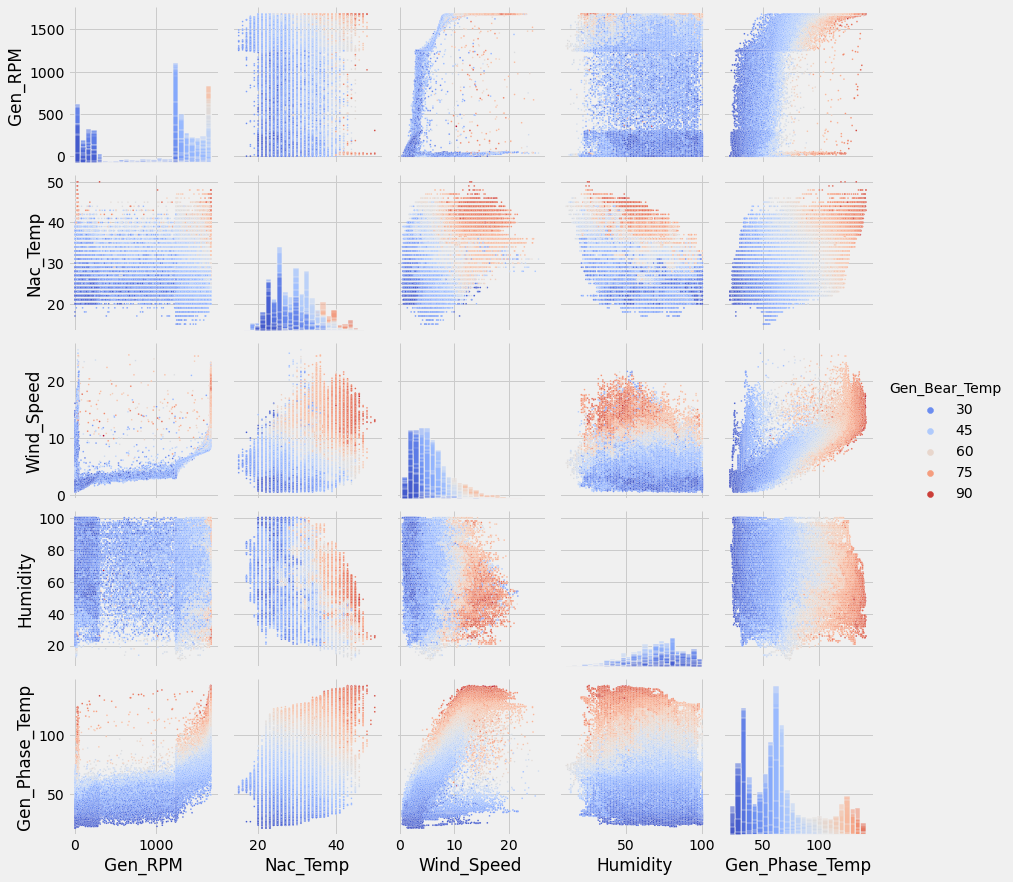

In [35]:
sns.pairplot(df, hue = "Gen_Bear_Temp", diag_kind = "hist", 
             diag_kws = {'alpha':0.55, 'bins':25}, palette = "coolwarm", plot_kws={"s": 3})

In [ ]:
df.loc[df['Humidity'] > 95]
#fig, ax = plt.subplots()
#fig.set(figwidth=8, dpi=100)
#ax.plot(df.index, df['Gen_Phase_Temp'])
plt.figure(figsize=(25, 10), dpi=80)
plt.plot(df.index[:90000], df['Humidity'][:90000])
#plt.plot(df.index[70000:90000], df['Gen_Bear_Temp'][70000:90000])
plt.show()

In [ ]:
span_lower =72000
span_higher = 80000
SD = np.std(prediction)
plt.figure(figsize=(25, 10), dpi=80)
plt.plot(df[span_lower:span_higher].index, df['Gen_Bear_Temp'][span_lower:span_higher], color='g', label='Measured')
plt.plot(df[span_lower:span_higher].index, prediction[span_lower:span_higher], color='r', label='Predicted')
plt.plot(df[span_lower:span_higher].index, prediction[span_lower:span_higher] - 2*SD, color='b', label='Predicted - 3SD')
plt.plot(df[span_lower:span_higher].index, prediction[span_lower:span_higher] + 2*SD, color='y', label='Predicted + 3SD')

plt.title('Actual Minus Predicted')
plt.ylabel('Generator Bearing Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(25,10), dpi=80)
points = ax.scatter(x_test[:, 3], x_test[:, 0], c=test_preds, s=25, cmap=cmap)
f.colorbar(points)
plt.show()

In [ ]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(25,10), dpi=80)
points = ax.scatter(x_test[:, 3], x_test[:, 0], c=y_test, s=25, cmap=cmap)
f.colorbar(points)
plt.show()

In [ ]:
# Find best value for k
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
from math import floor, sqrt

section = (1-test_size)*len(df[:])
section = floor(section)
accuracy_score = accuracy_score(prediction[section:], y_test)
print(f"'Accuracy score' from sklearn: {accuracy_score}")

# RMSE for training period
train_preds = knn.predict(x_train)
mse = mean_squared_error(y_train, train_preds)
train_rmse = sqrt(mse)
print(f'RMSE for training period: {train_rmse}')

# RMSE for testing period
test_preds = knn.predict(x_test)
mse = mean_squared_error(y_test, test_preds)
test_rmse = sqrt(mse)
print(f'RMSE for testing period: {test_rmse}')


# RMSE adding GridSearchCV
parameters = {"n_neighbors": range(1, 50)}
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
gridsearch.fit(x_train, y_train)

print(f'Optimal {gridsearch.best_params_}')
train_preds_grid = gridsearch.predict(x_train)
train_mse = mean_squared_error(y_train, train_preds_grid)
grid_train_rmse = sqrt(train_mse)
test_preds_grid = gridsearch.predict(x_test)
test_mse = mean_squared_error(y_test, test_preds_grid)
grid_test_rmse = sqrt(test_mse)
print(f'RMSE using GridSearchCV for training period: {grid_train_rmse}')
print(f'RMSE using GridSearchCV for testing period: {grid_test_rmse}')


# RMSE adding weighted average of neighbors based on distance
parameters = {
"n_neighbors": range(1, 50),
"weights": ["uniform", "distance"],
}
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
gridsearch.fit(x_train, y_train)

gridsearch.best_params_
test_preds_grid = gridsearch.predict(x_test)
test_mse = mean_squared_error(y_test, test_preds_grid)
weighed_test_rmse = sqrt(test_mse)
print(f'RMSE adding weighted average of neighbors based on distance: {weighed_test_rmse}')

data = {'Arbitrary k': test_rmse,
        'GridSearchCV for k': grid_test_rmse,
        'GridSearchCV for k and weights': weighed_test_rmse
       }
pd.DataFrame.from_dict(data, orient='index', columns=['RMSE'])

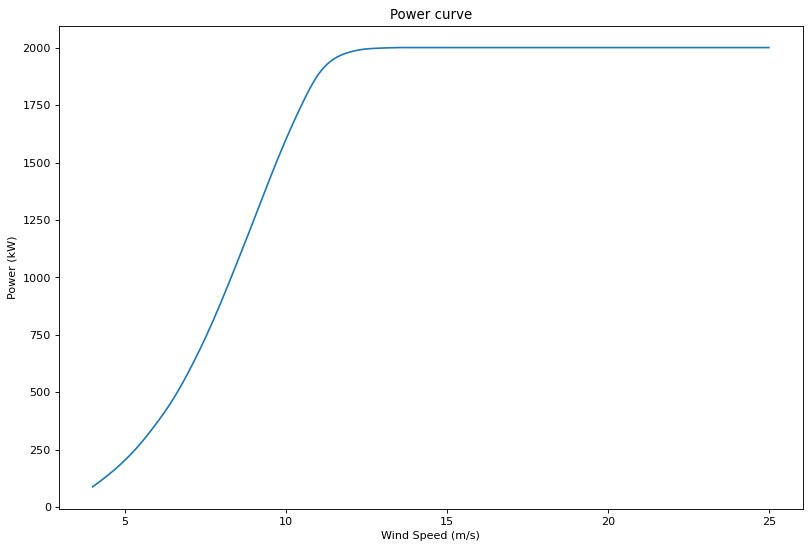

In [55]:
df_powercurve = pd.read_excel('powercurve.xlsx')

# Plot power curve
from scipy.interpolate import make_interp_spline, BSpline
df_pc = pd.read_excel('powercurve.xlsx')

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(df_pc['WindSpeed'].min(), df_pc['WindSpeed'].max(), 300) 

spl = make_interp_spline(df_pc['WindSpeed'], df_pc['Power'], k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.figure(figsize=(12, 8), dpi=80)
plt.plot(xnew, power_smooth)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.title('Power curve')
plt.show()

In [ ]:
# Export df to table in docx
import docx

# open an existing document
doc = docx.Document('./test.docx')

# add a table to the end and create a reference variable
# extra row is so we can add the header row
t = doc.add_table(df_dupl.shape[0]+1, df_dupl.shape[1])

# add the header rows.
for j in range(df_dupl.shape[-1]):
    t.cell(0,j).text = df_dupl.columns[j]

# add the rest of the data frame
for i in range(df_dupl.shape[0]):
    for j in range(df_dupl.shape[-1]):
        t.cell(i+1,j).text = str(df_dupl.values[i,j])

# save the doc
doc.save('./test.docx')

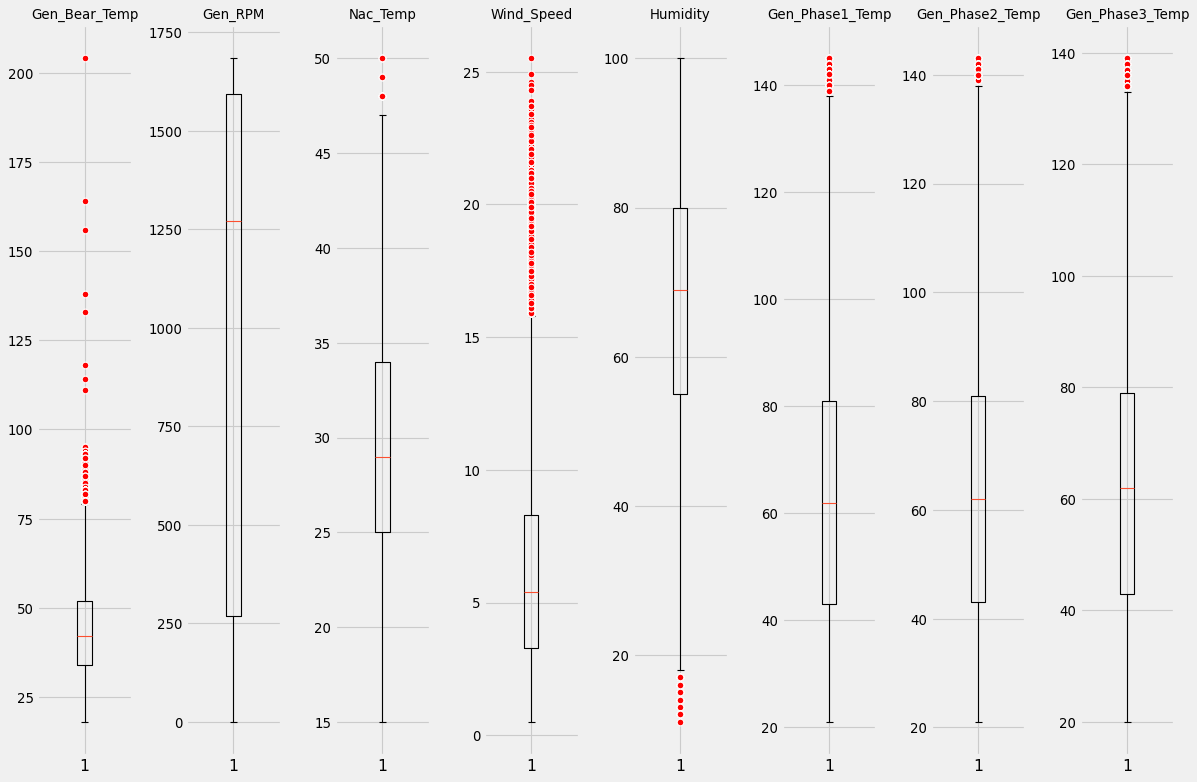

In [29]:
#Creating box plot of each column with its own scale
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

fig, axs = plt.subplots(1, len(df.columns), figsize=(15,10), dpi=80)

for i, ax in enumerate(axs.flat):
    ax.boxplot(df.iloc[:,i].dropna(), flierprops=red_circle)
    ax.set_title(df.columns[i], fontsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
plt.tight_layout()
plt.show()

In [33]:
# Correlation matrix
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Gen_Bear_Temp,Gen_RPM,Nac_Temp,Wind_Speed,Humidity,Gen_Phase_Temp
Gen_Bear_Temp,1.00,0.70,0.72,0.83,-0.32,0.97
Gen_RPM,0.70,1.00,0.30,0.68,-0.15,0.78
Nac_Temp,0.72,0.30,1.00,0.50,-0.49,0.57
Wind_Speed,0.83,0.68,0.50,1.00,-0.22,0.87
Humidity,-0.32,-0.15,-0.49,-0.22,1.00,-0.23
Gen_Phase_Temp,0.97,0.78,0.57,0.87,-0.23,1.00
